## Multi class Sentiment analysis 

In [83]:

#Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')
stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anilsorathiya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data

In [84]:
train=pd.read_csv("../datasets/nlp/classification/covid_tweets/Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("../datasets/nlp/classification/covid_tweets/Corona_NLP_test.csv",encoding='latin1')


df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [85]:
print(" Shape of dataframe after dropping duplicates: ", df.shape)
# Drop duplicates
df.drop_duplicates(inplace=True)
train.drop_duplicates(inplace=True)
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (44955, 6)
 Shape of dataframe after dropping duplicates:  (44955, 6)


In [4]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [5]:
# We will copy the text in another column so that the original text is also there for comparison

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)

positive    0.435814
negative    0.378846
neutral     0.185341
Name: sentiment, dtype: float64

### Class distribution 

In [6]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


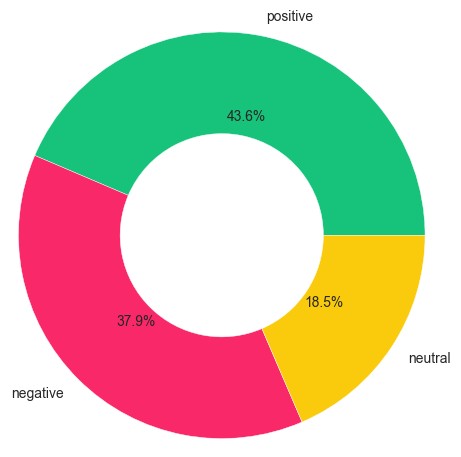

In [7]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

In [8]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

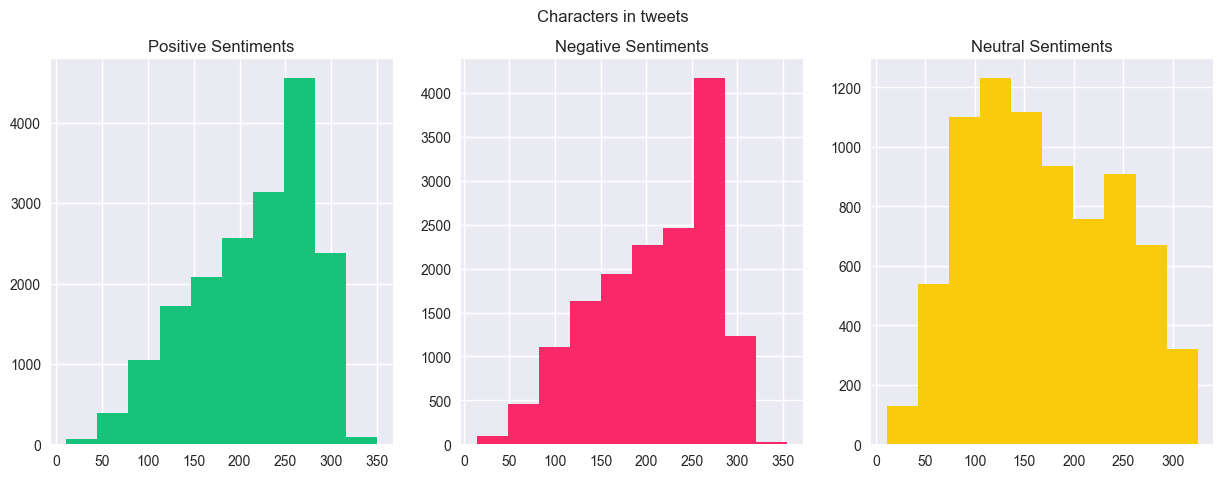

In [9]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

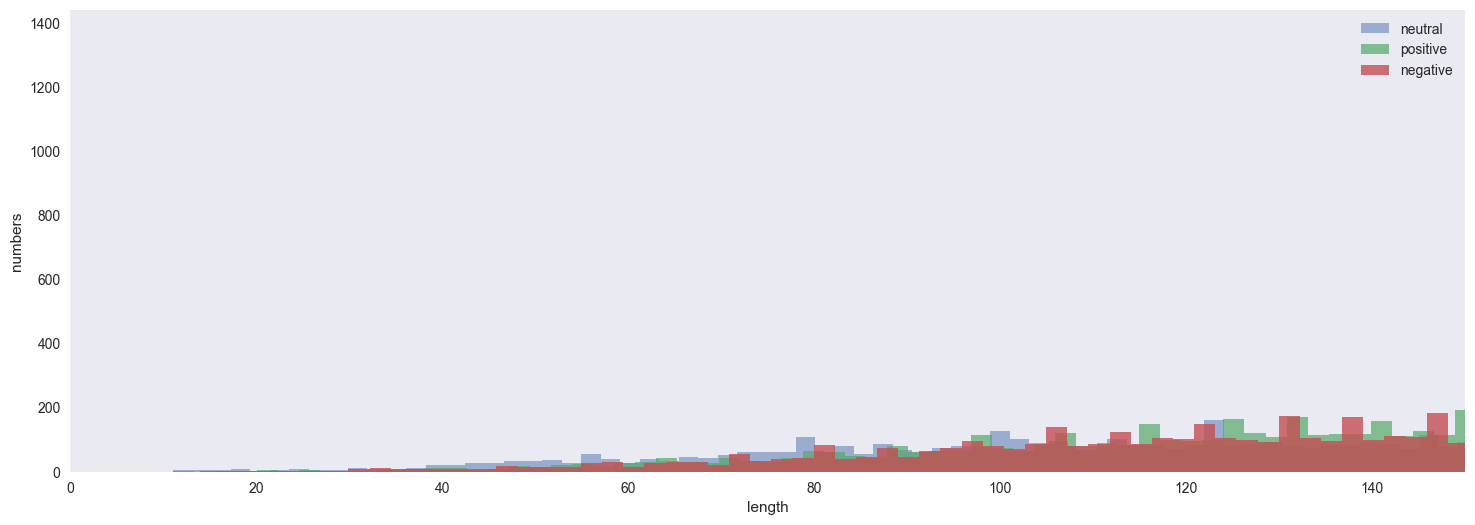

In [10]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(df[df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(df[df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

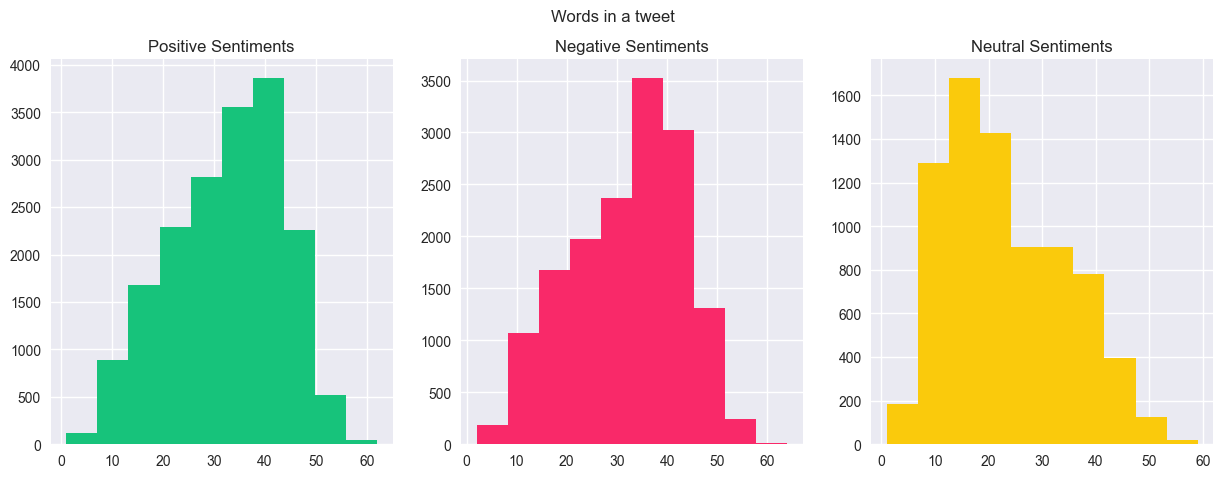

In [11]:

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

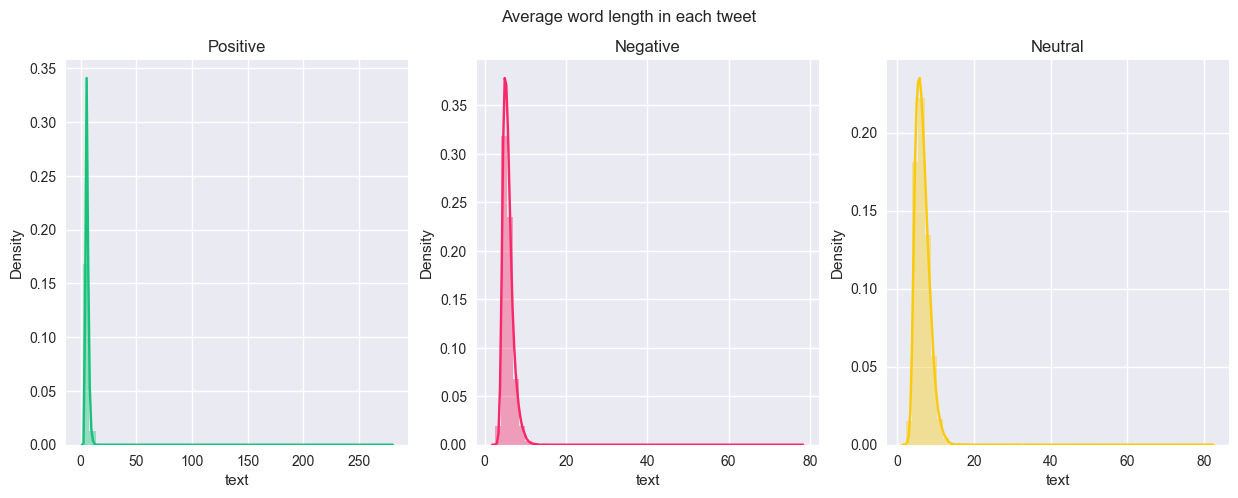

In [12]:

fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=train[train['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=train[train['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

In [13]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [14]:
np.array(stop)


array({'myself', 'out', 'now', 'these', 'been', 'their', 'does', 'have', 'your', "shouldn't", 'by', 'am', "wasn't", 'during', 'until', 'be', 'himself', 'into', 'whom', 'they', 'at', "mightn't", 'where', 'for', 'up', 'because', 'are', 'a', 'very', 'after', 'those', 'should', 'you', 'ourselves', 'no', 'than', 'y', 't', 'hasn', 'isn', 'them', "wouldn't", 'all', 'him', 's', 'some', 'below', "couldn't", 'my', 'has', 'over', 'any', 'an', 'through', 'o', 'only', 'such', "aren't", 'her', 'about', 'while', 'once', 'being', "didn't", 'our', "won't", 'just', 'when', "that'll", 'won', 'nor', 'again', 'was', 'or', 'against', 'yourself', 'to', 'herself', 'ours', 'down', 'mustn', 'so', 'other', "it's", 'we', 'what', 'didn', 'same', 'before', 'which', 'on', 'further', "needn't", 'is', 'above', 'needn', 'both', 'wouldn', 'do', 'she', 'that', "you'd", 'in', 'there', 'itself', "hadn't", 'hadn', 'each', 'of', 'shan', 'from', 'but', 'under', 'yours', 'it', 'off', 'doing', 'will', "weren't", 'me', 'with', '

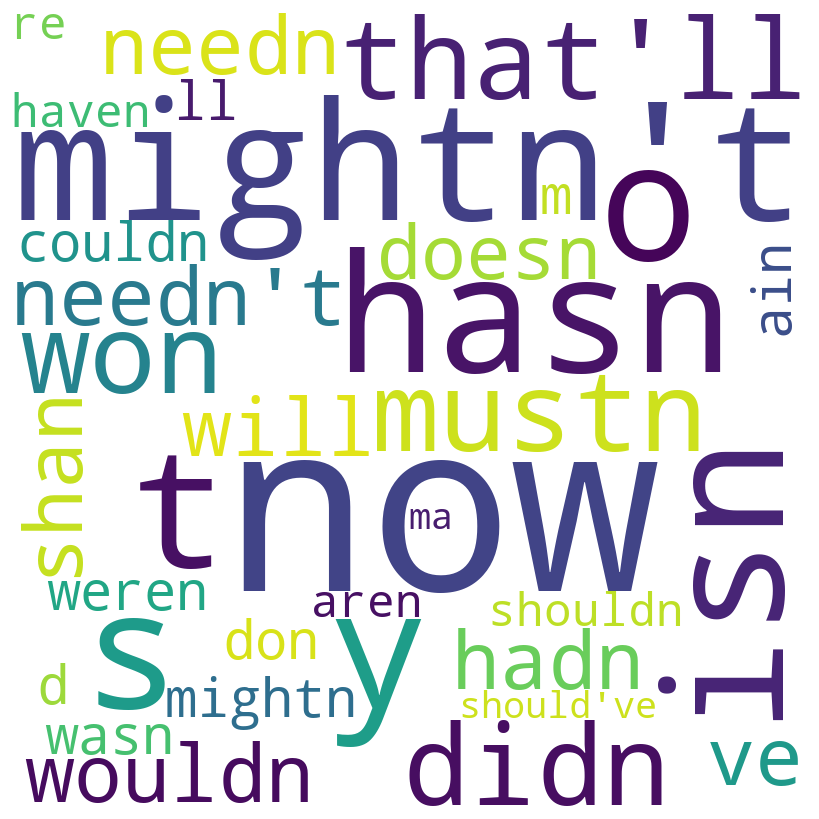

In [15]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 


<BarContainer object of 10 artists>

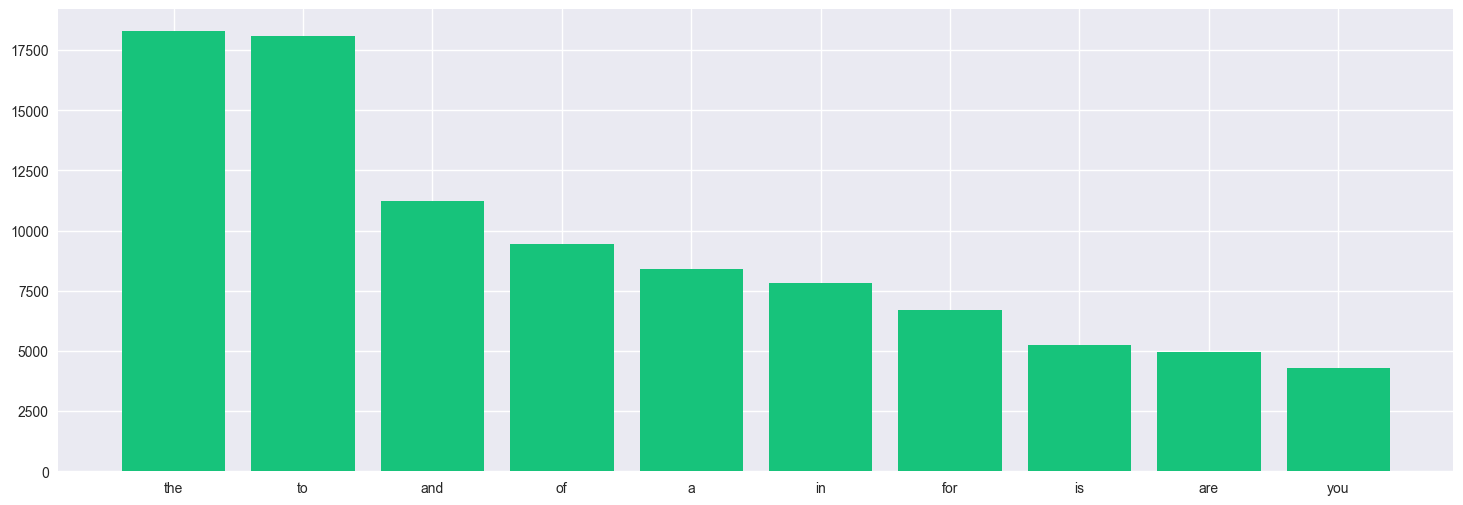

In [16]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

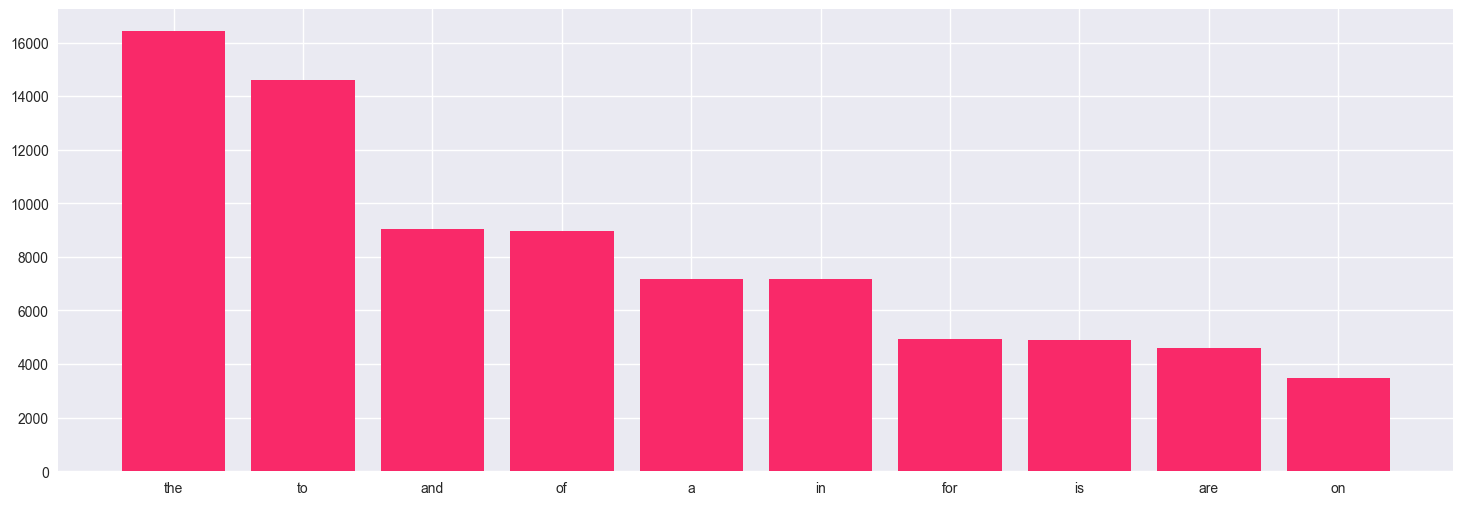

In [17]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

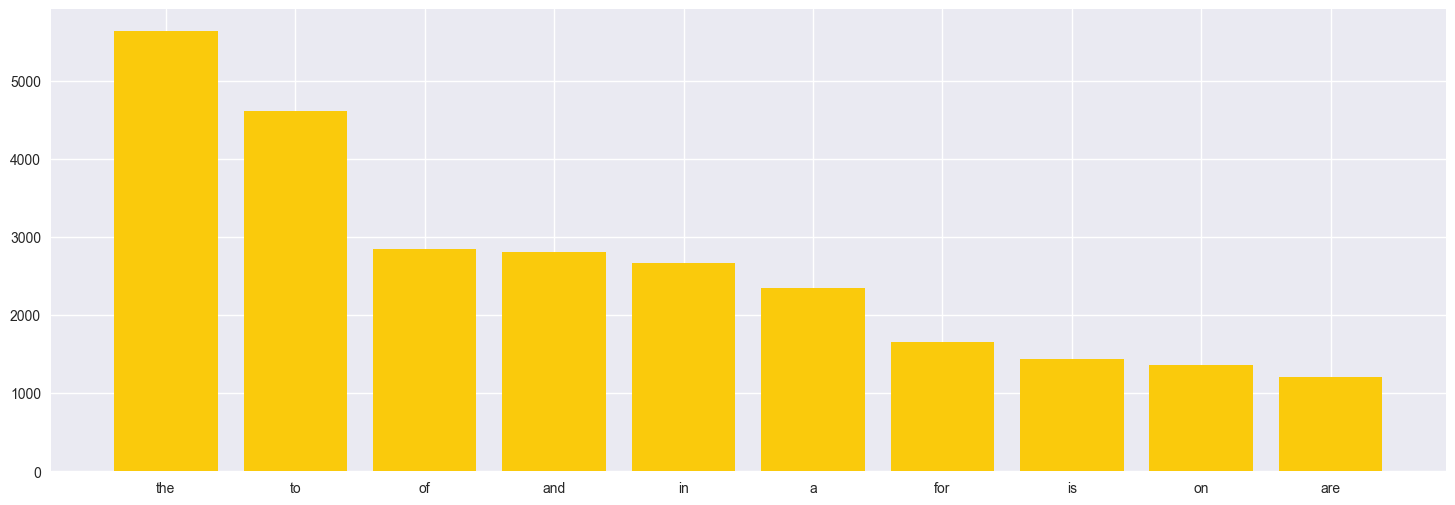

In [18]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

#### Punctuations

<BarContainer object of 27 artists>

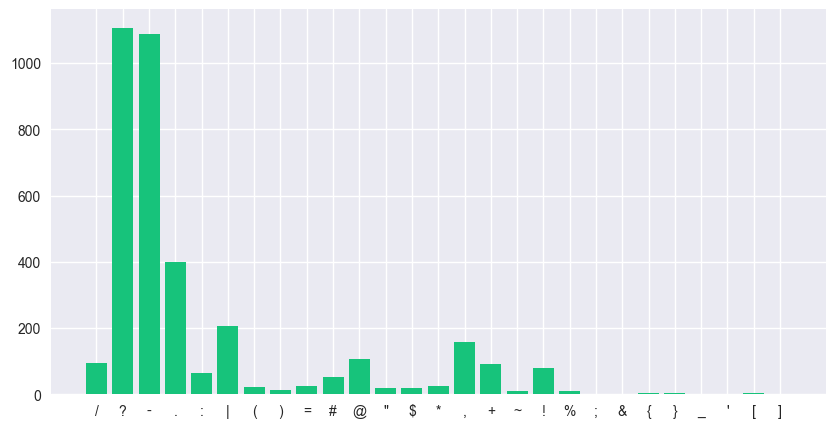

In [19]:
plt.figure(figsize=(10,5))
corpus=create_corpus("positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 25 artists>

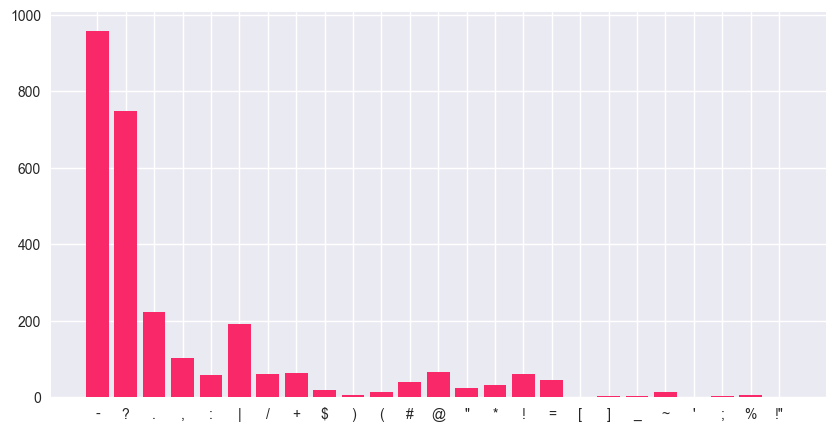

In [20]:
plt.figure(figsize=(10,5))
corpus=create_corpus("negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

#### Common words

In [21]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Axes: >

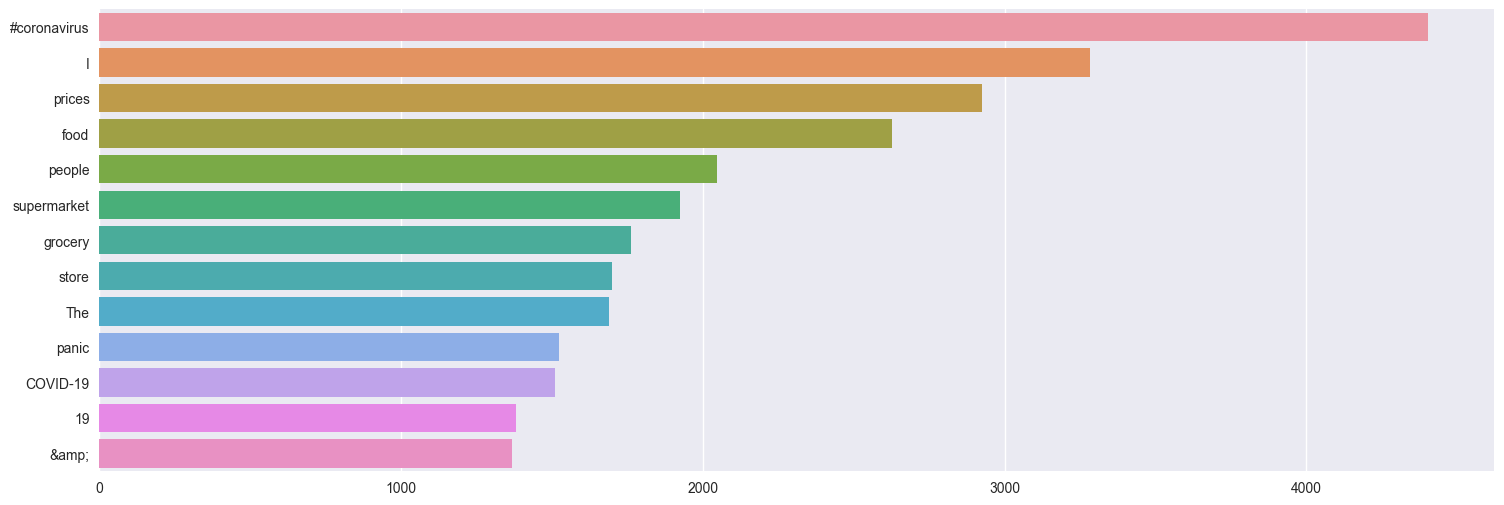

In [22]:
sns.barplot(x=y,y=x)


#### Hashtags

<Axes: xlabel='Hashtag', ylabel='count'>

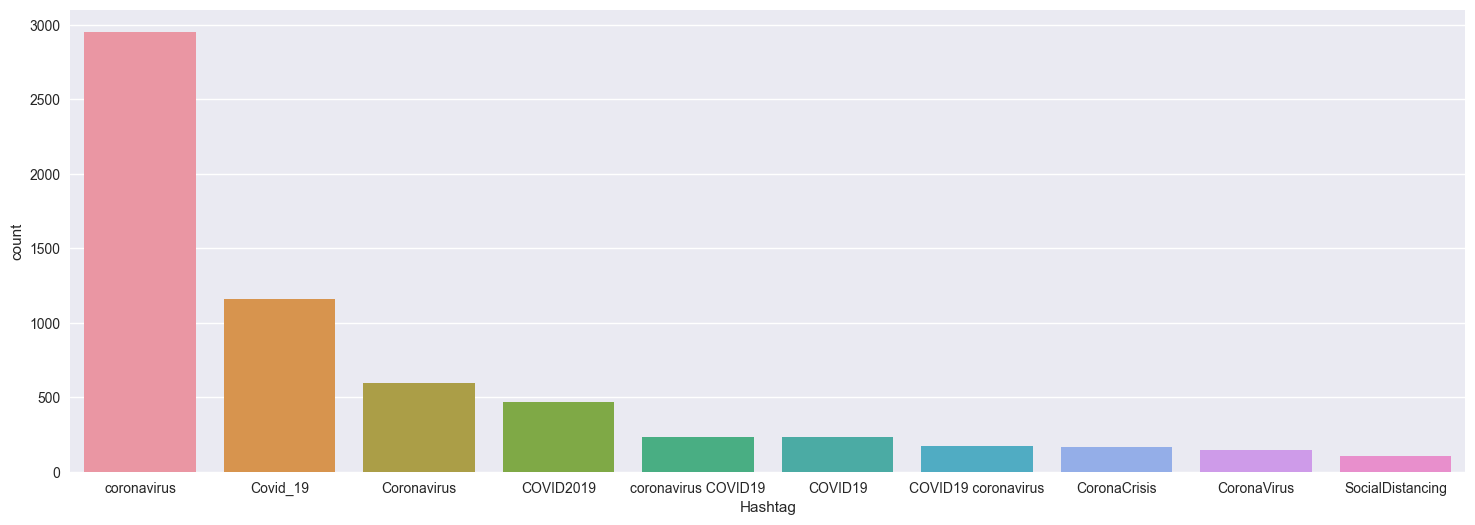

In [23]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

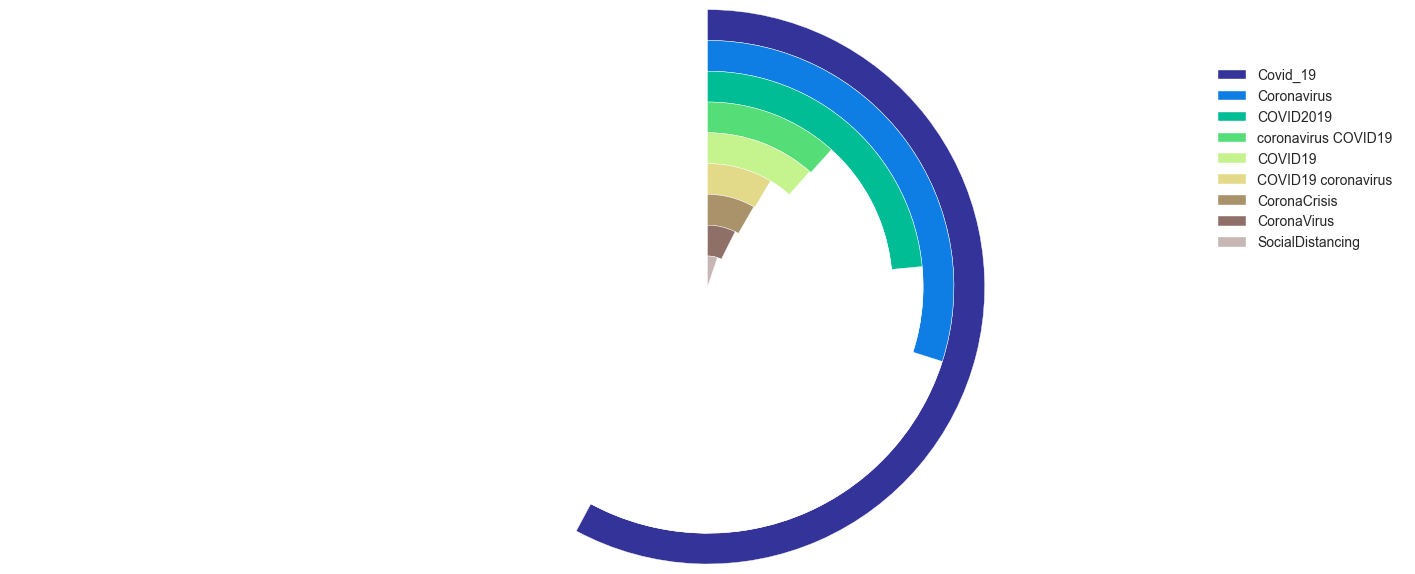

In [24]:
from matplotlib import cm
from math import log10

labels = df['hash'].value_counts()[:][2:11].index.tolist()
data = df['hash'].value_counts()[:][2:11]

df['hash'].value_counts()[:][1:11].index.tolist()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

#### Mentions



<Axes: xlabel='Mentions', ylabel='count'>

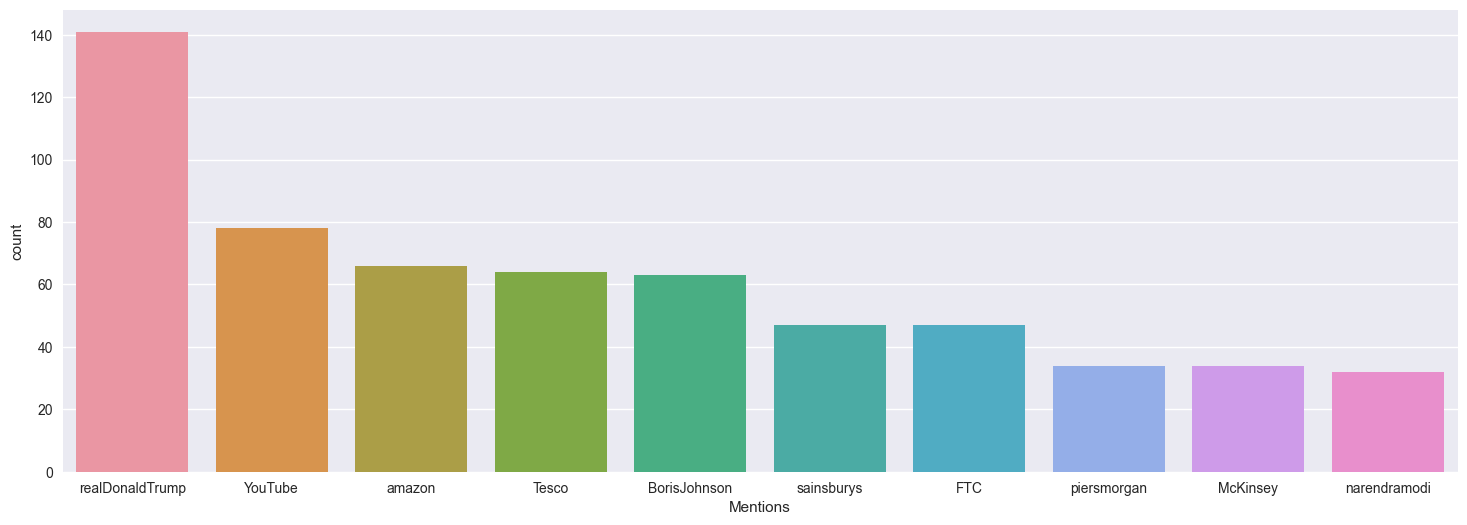

In [25]:
def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)

In [26]:
b = df['mentions'].value_counts()[:][1:11].index.tolist()
a = df['mentions'].value_counts()[:][1:11].tolist()
row = pd.DataFrame({'scenario' : []})
row["scenario"] = b
row["Percentage"] = a
fig = px.treemap(row, path= ["scenario"], values="Percentage",title='Tree of Mentions')
fig.show()

### Pre processing

In [27]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text_new']=df['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text_new'].apply(lambda x:remove_html(x))

In [28]:
# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['text_new']=df['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['text']=df['text_new'].apply(lambda x:remove_num(x))


In [29]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['text_new']=df['text'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text']=df['text_new'].apply(lambda x:remove_stopwords(x))

In [30]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['text_new']=df['text'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['text']=df['text_new'].apply(lambda x:remove_hash(x))


In [31]:
#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['text_new']=df['text'].apply(lambda x:remove_space(x))

df = df.drop(columns=['text_new'])

#### Wordclouds



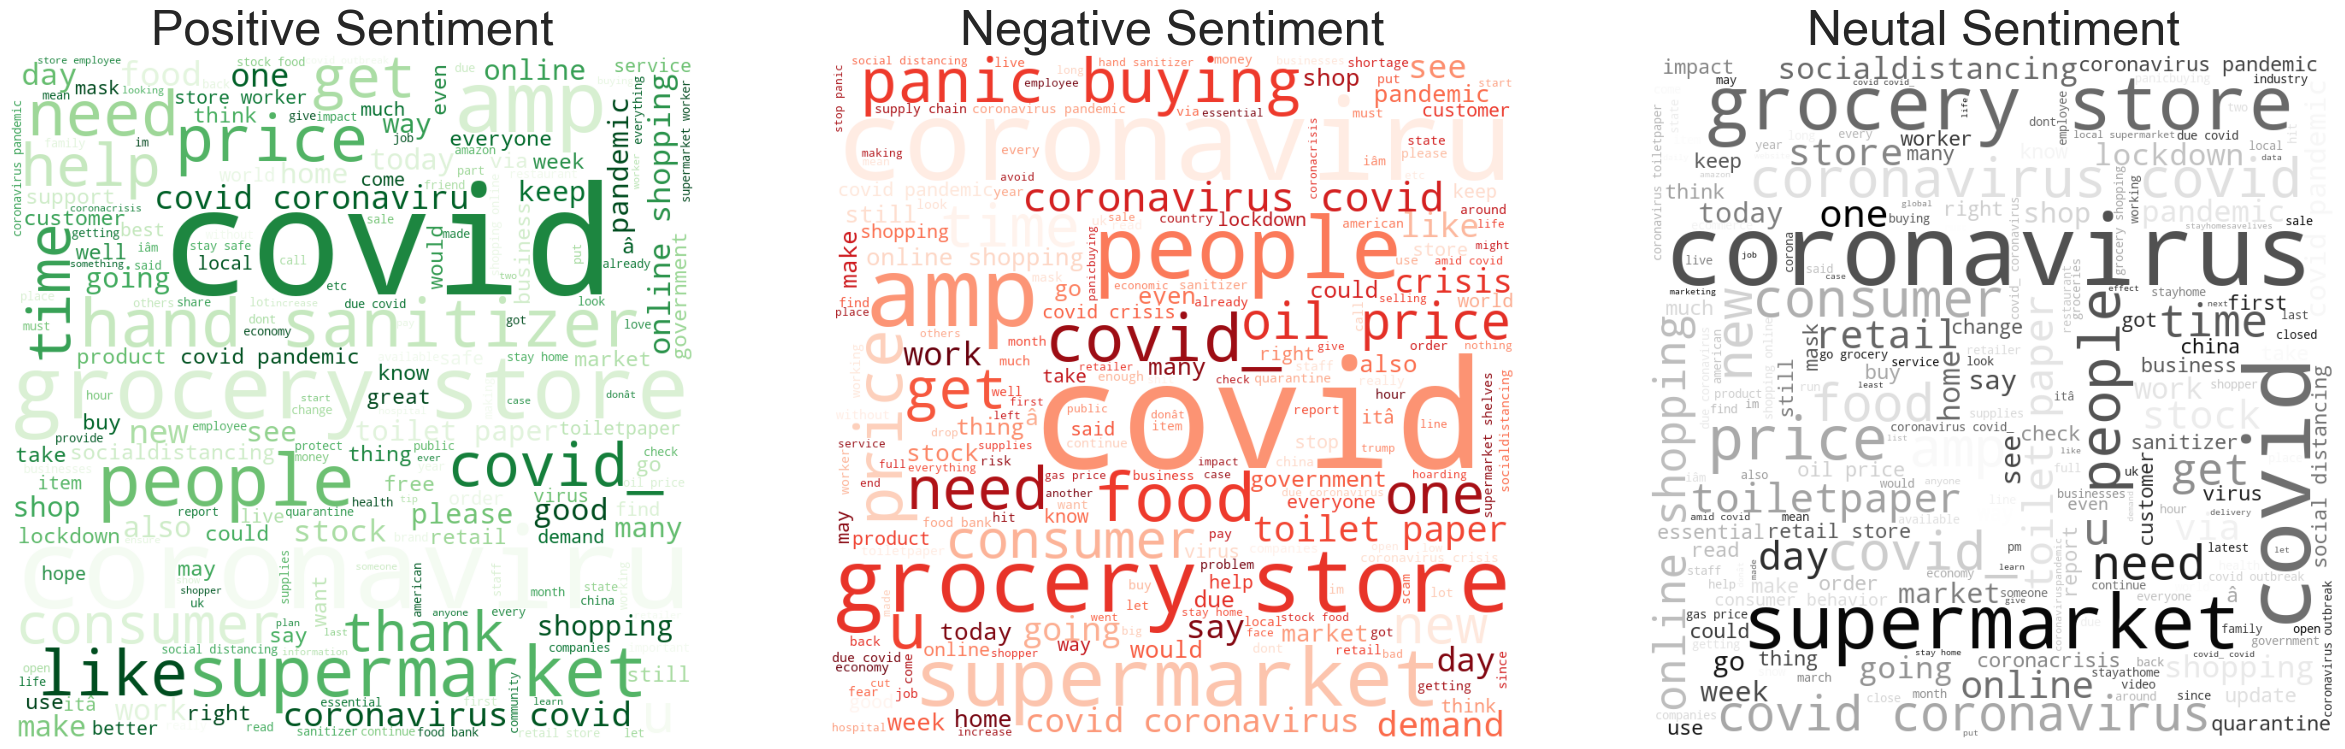

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["sentiment"]=="positive"]
df_neg = df[df["sentiment"]=="negative"]
df_neu = df[df["sentiment"]=="neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in df_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in df_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

#### N-grams



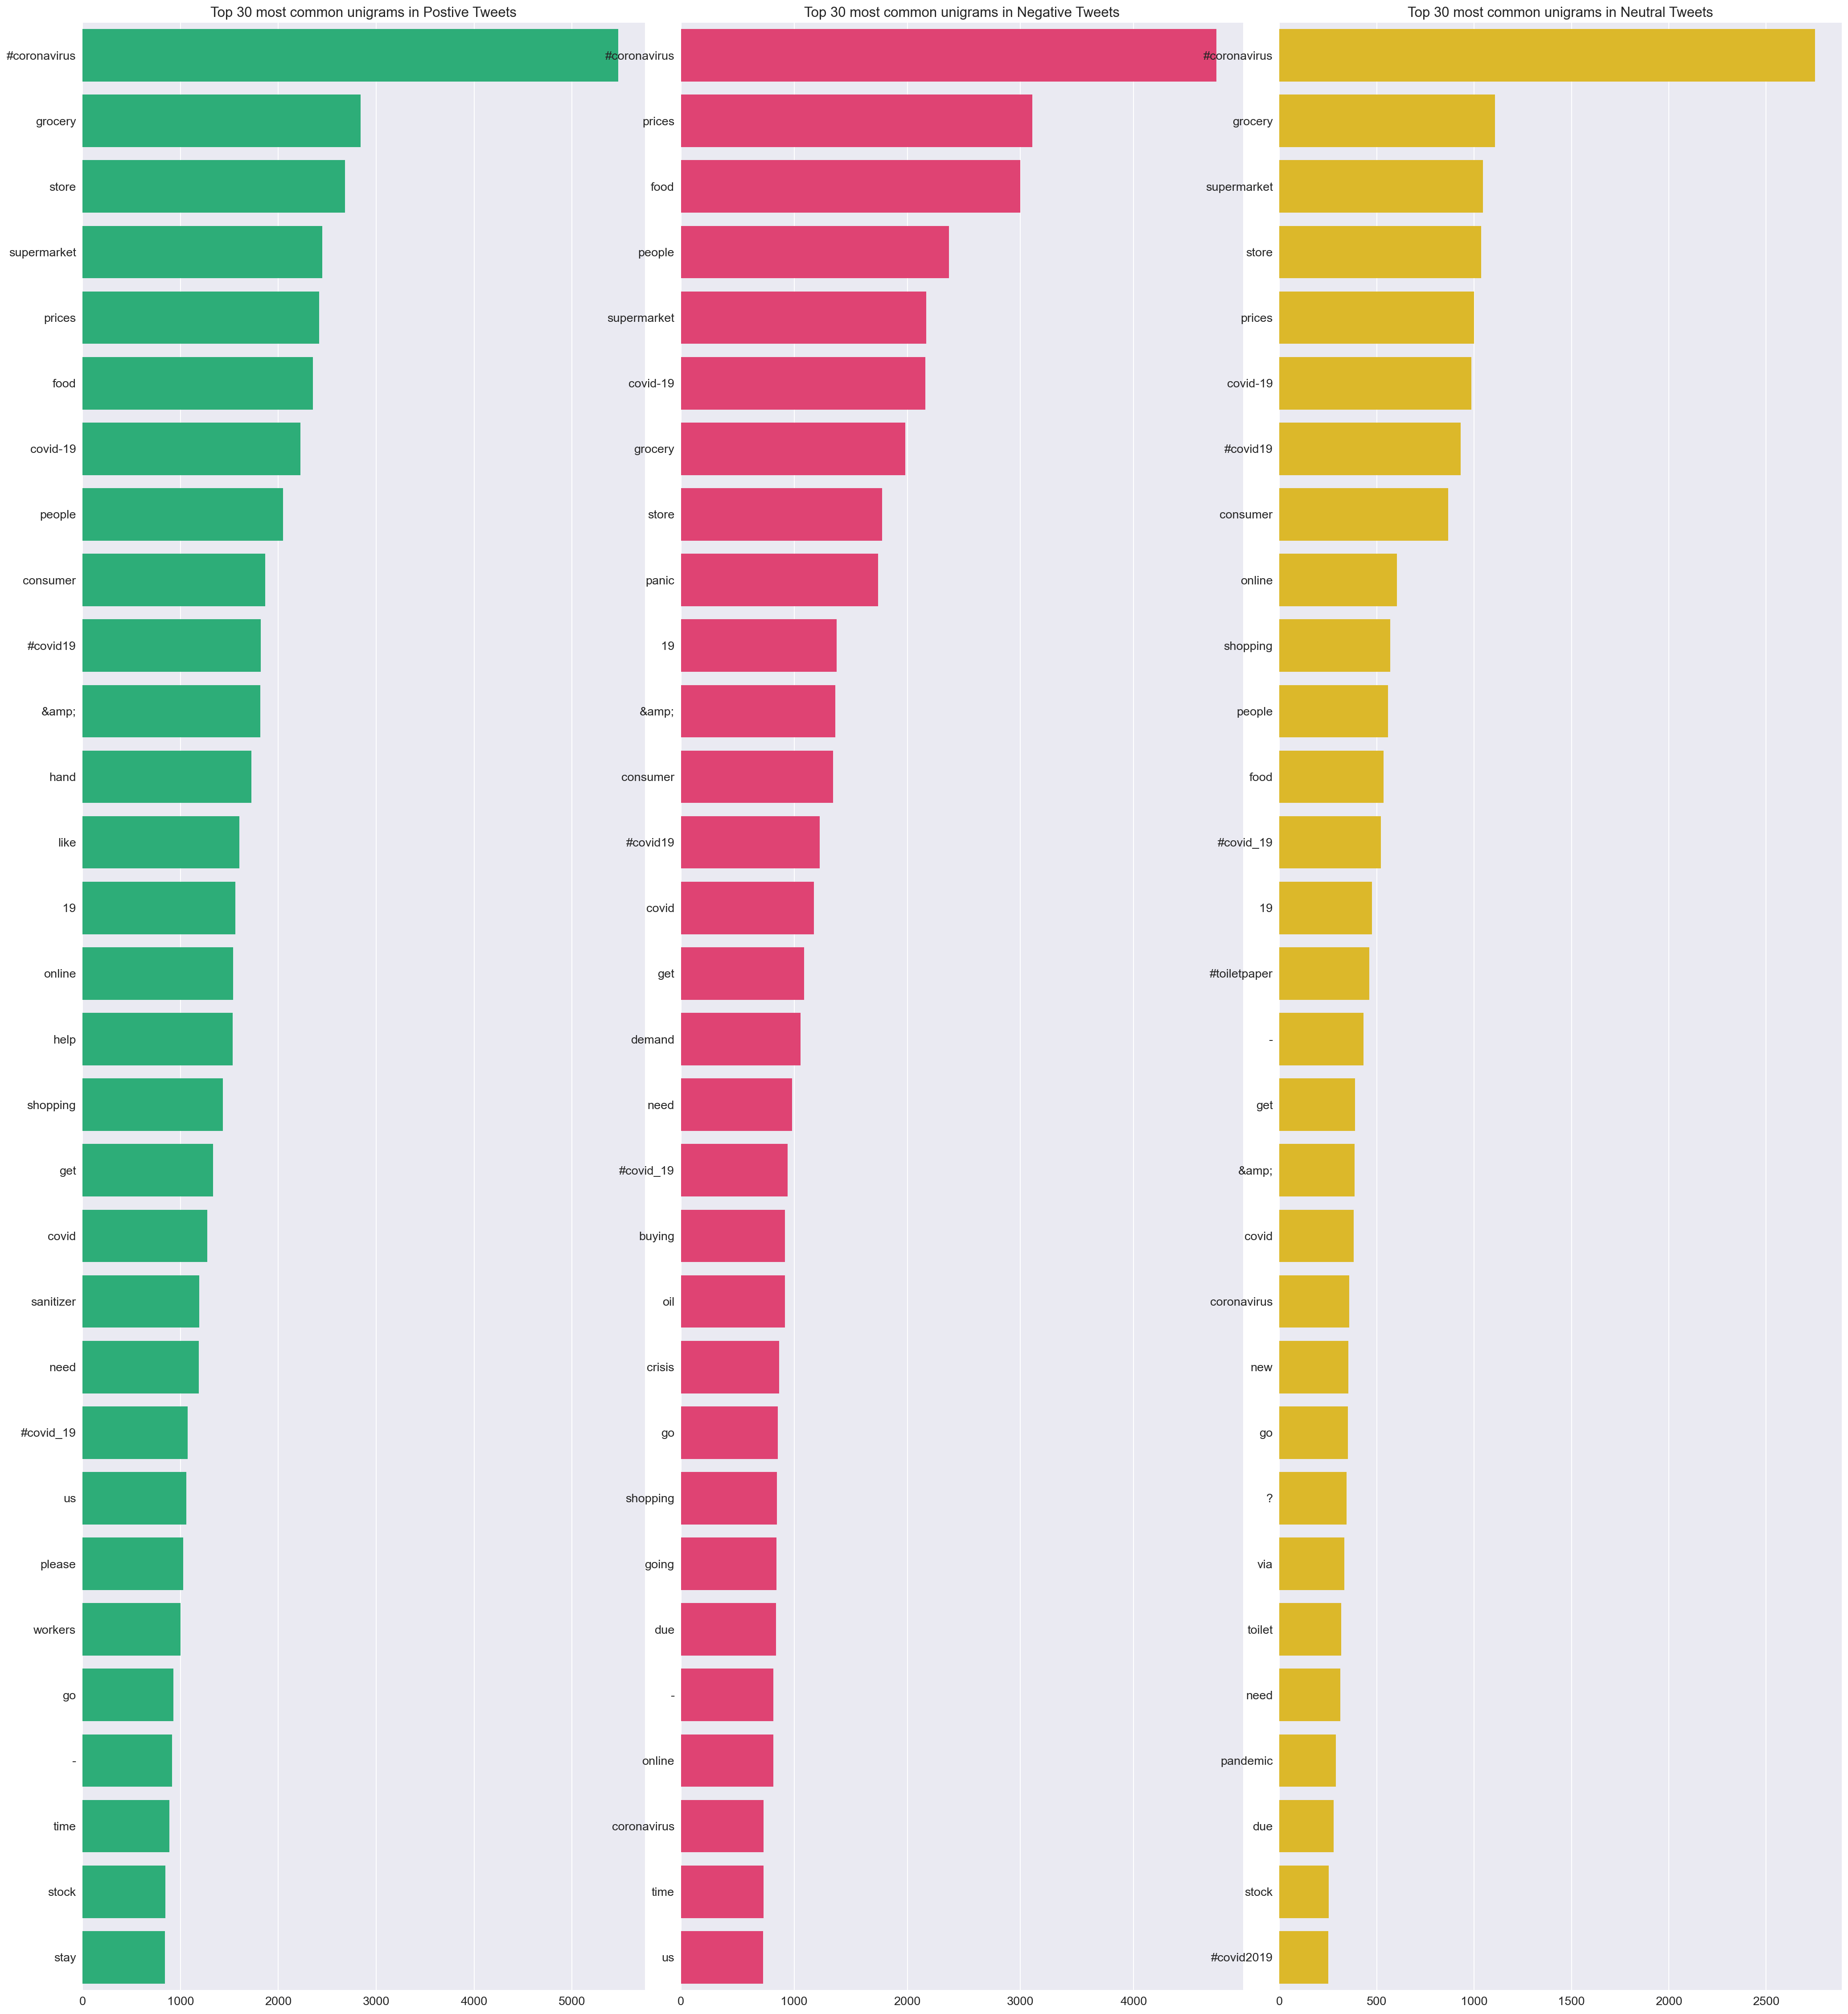

In [33]:
## unigram

# Define functions
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 30



positive= train["sentiment"]== "positive"
negative= train["sentiment"]== "negative"
neutral= train["sentiment"]== "neutral"

positive_unigrams = defaultdict(int)
neutral_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Unigrams
for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet):
        positive_unigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet):
        negative_unigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet):
        neutral_unigrams[word] += 1        
        
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_unigrams = pd.DataFrame(sorted(neutral_unigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=df_positive_unigrams[0].values[:N], x=df_positive_unigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_unigrams[0].values[:N], x=df_negative_unigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_unigrams[0].values[:N], x=df_neutral_unigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)

plt.show()

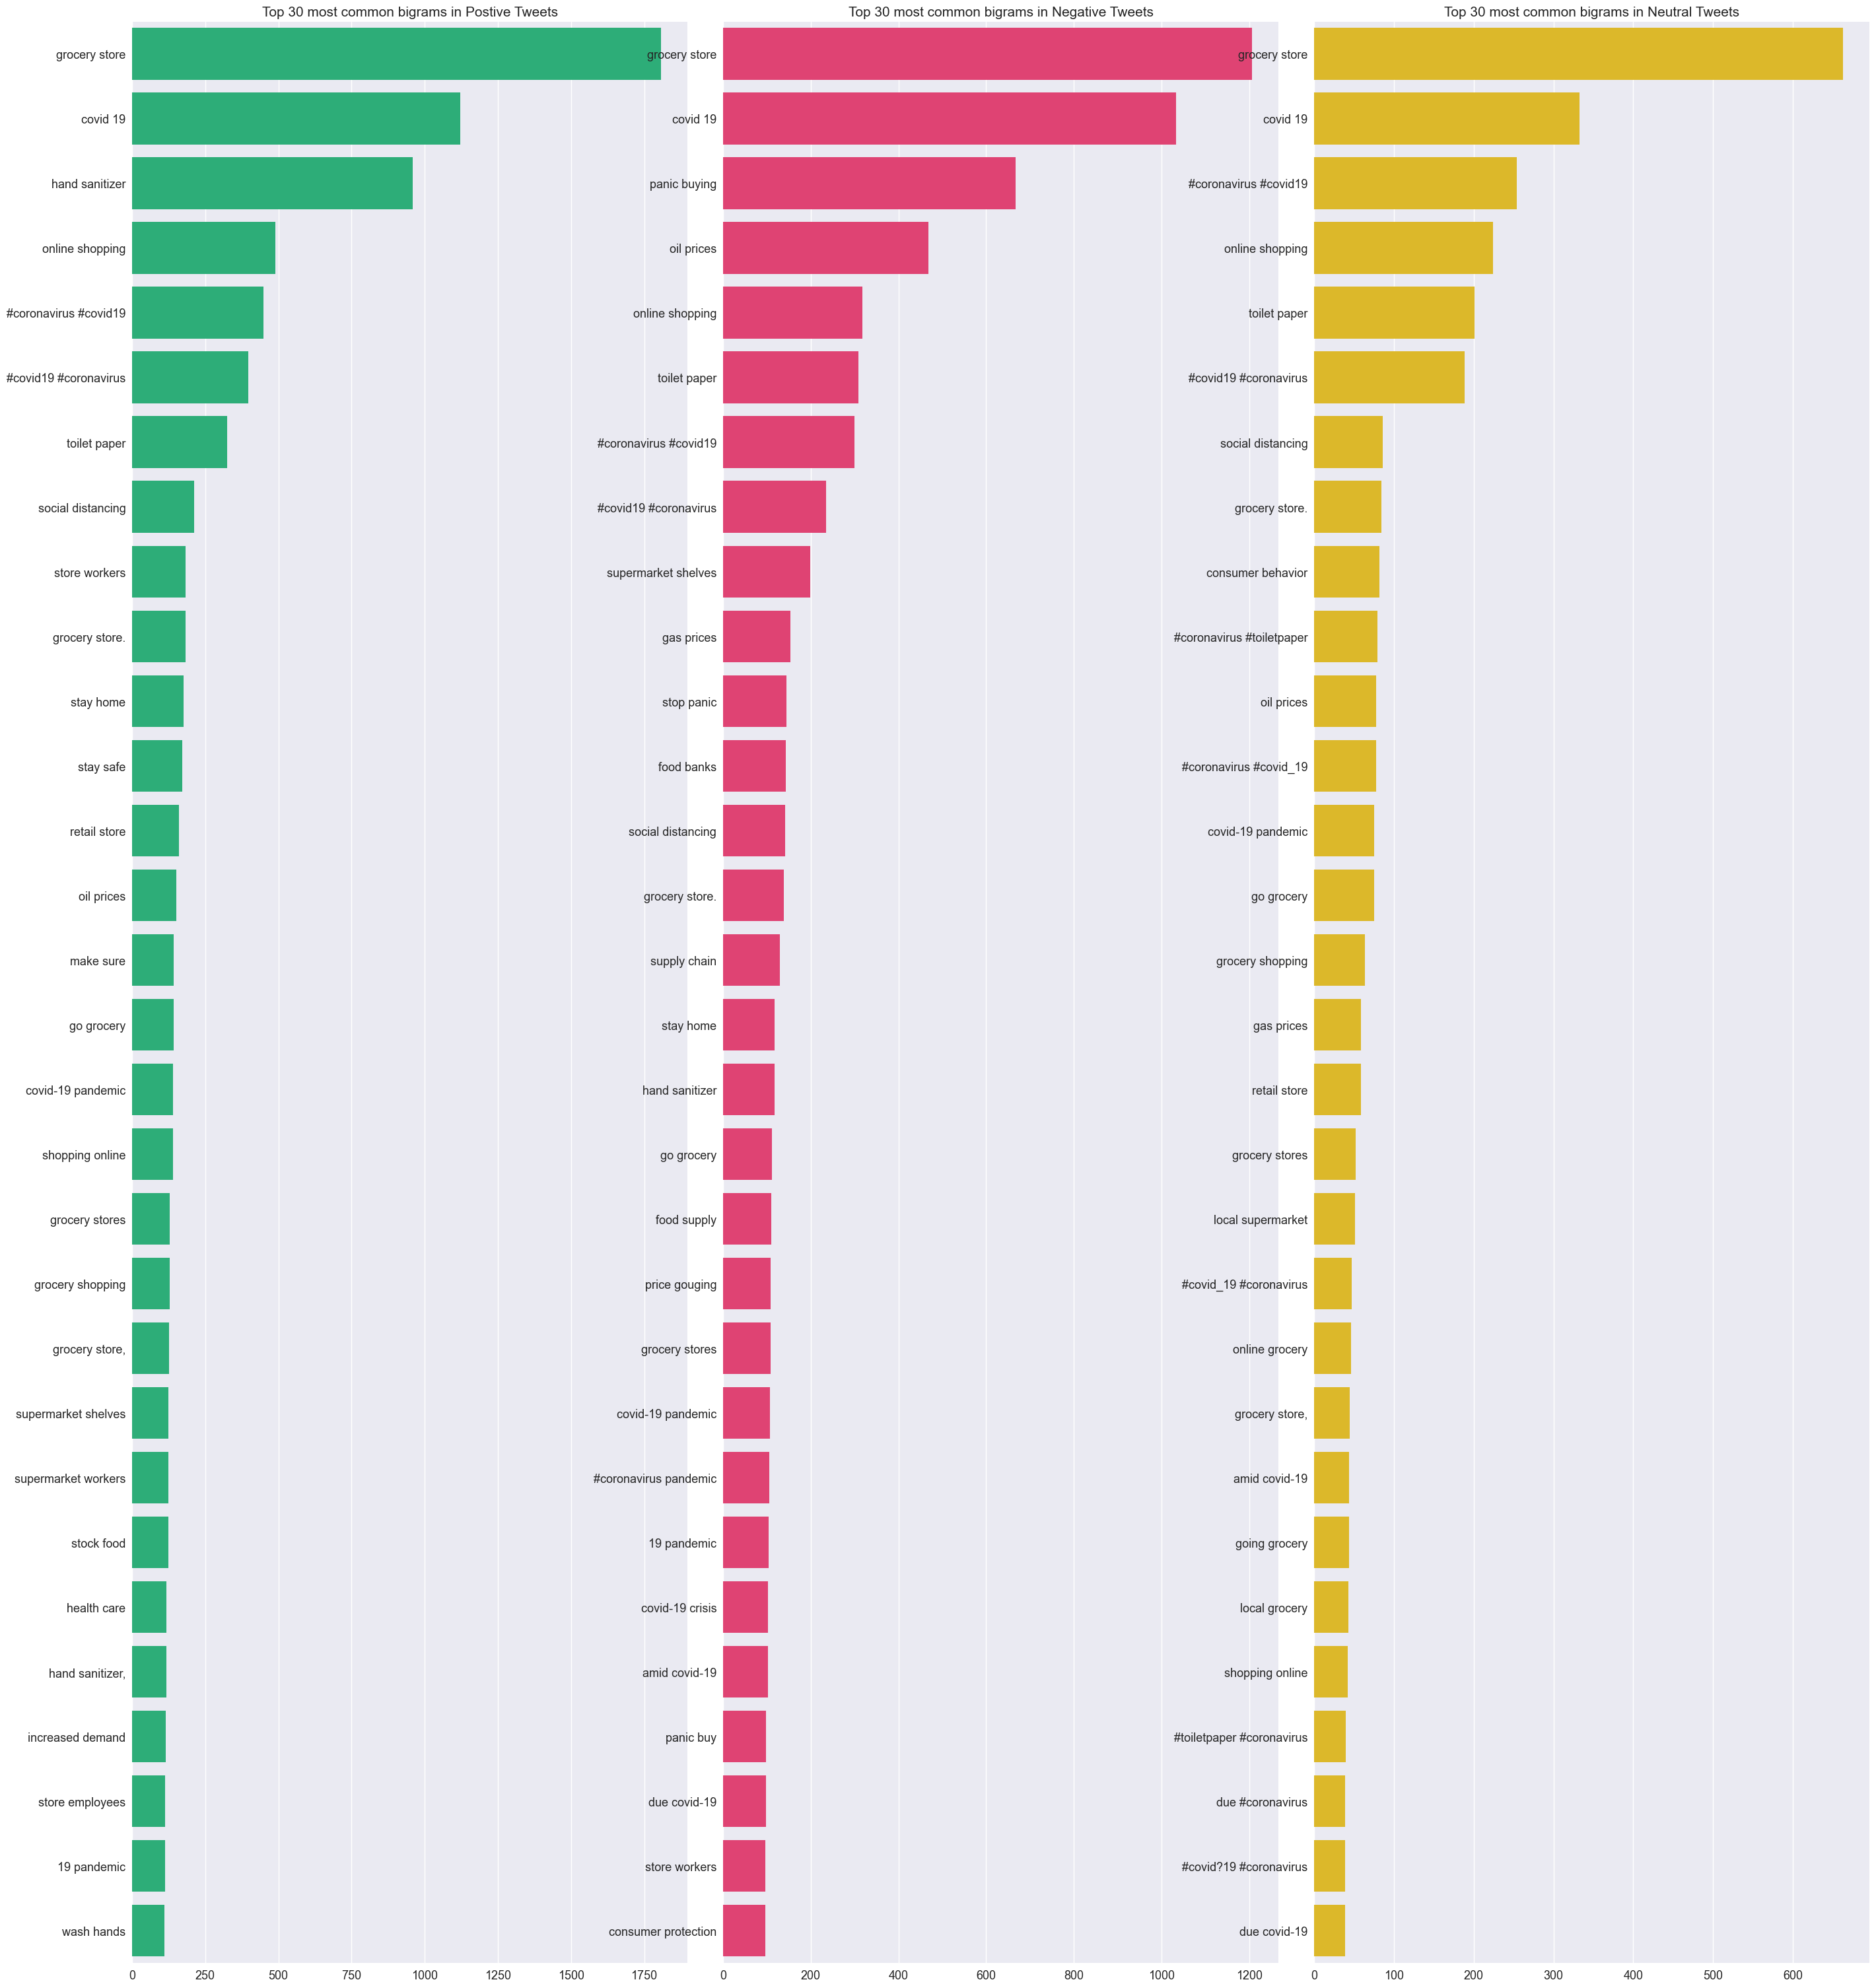

In [34]:
## Bi grams
# Bigrams
positive_bigrams = defaultdict(int)
neutral_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        positive_bigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        negative_bigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        neutral_bigrams[word] += 1        
        
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_bigrams = pd.DataFrame(sorted(neutral_bigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_bigrams[0].values[:N], x=df_negative_bigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_bigrams[0].values[:N], x=df_neutral_bigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Neutral Tweets', fontsize=15)

plt.show()

#### Tri-grams


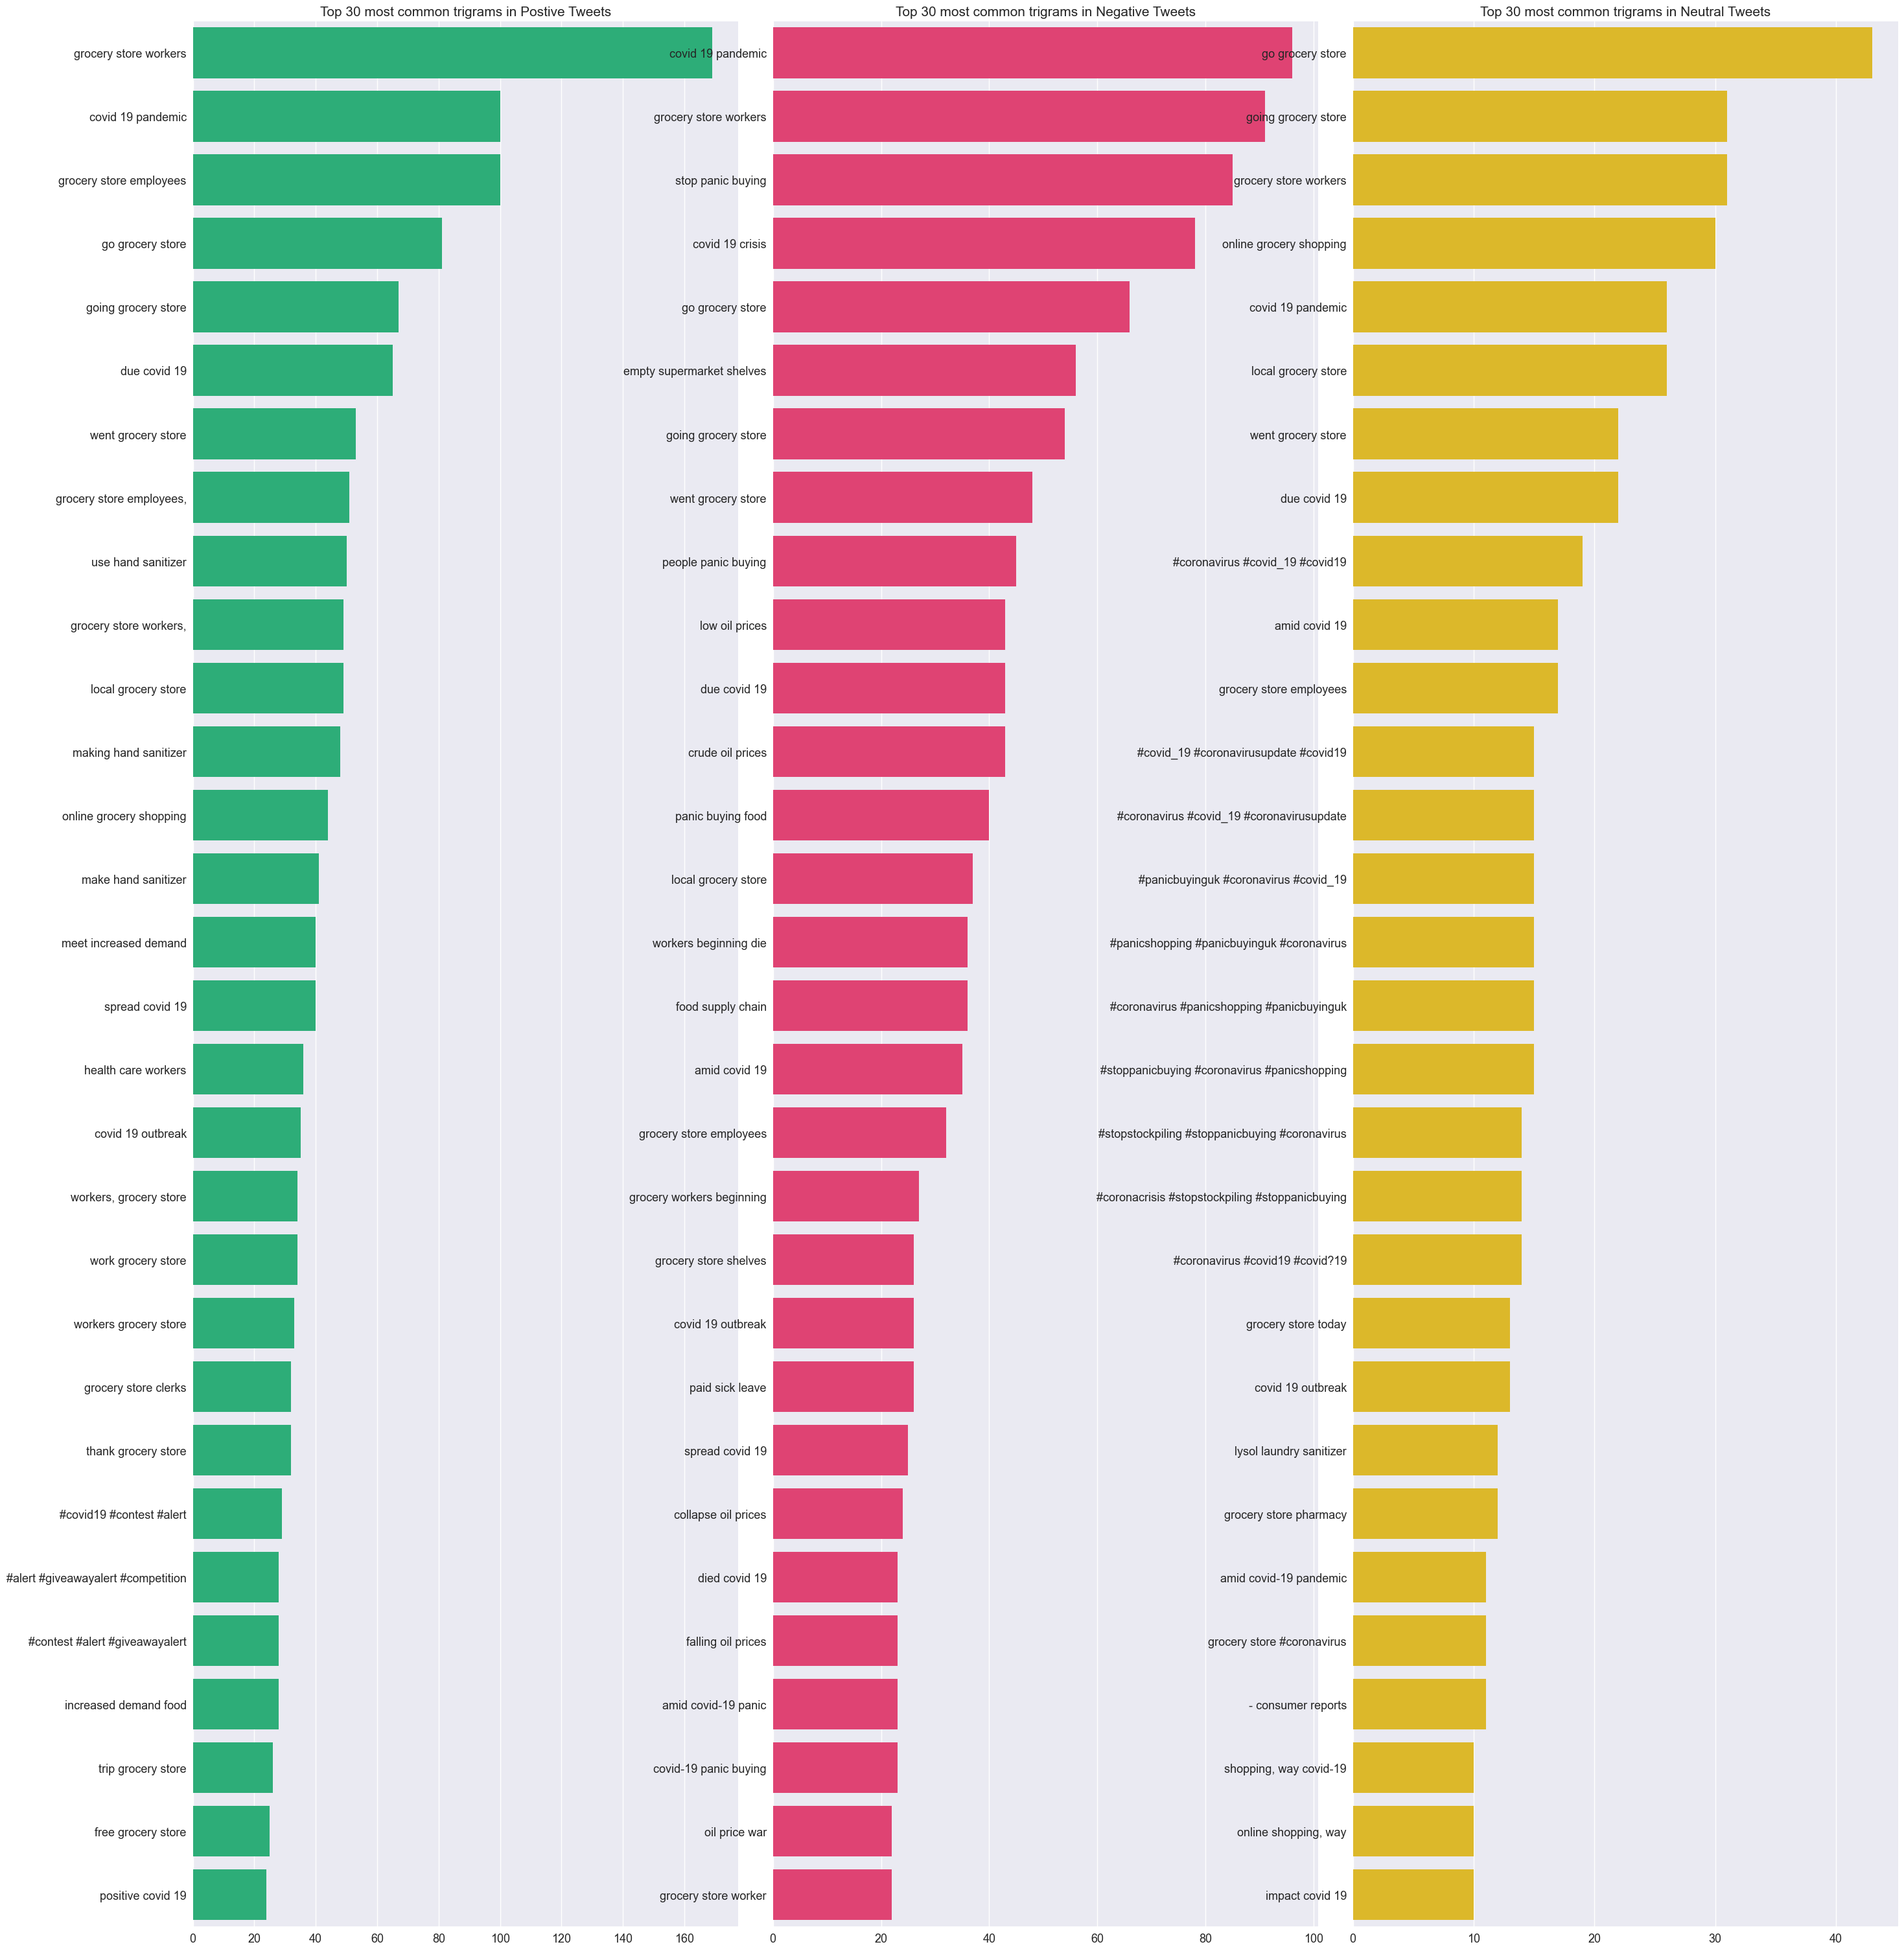

In [35]:
# Trigrams
positive_trigrams = defaultdict(int)
neutral_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        positive_trigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        negative_trigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        neutral_trigrams[word] += 1        
        
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_trigrams = pd.DataFrame(sorted(neutral_trigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_trigrams[0].values[:N], x=df_positive_trigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_trigrams[0].values[:N], x=df_negative_trigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_trigrams[0].values[:N], x=df_neutral_trigrams[1].values[:N], ax=axes[2], color='#FACA0C')




for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common trigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Neutral Tweets', fontsize=15)

plt.show()

## Modeling

In [36]:
!pip install tensorflow_hub
!pip install tensorflow_text
!pip install tensorflow


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement tensorflow_text (from versions: none)
ERROR: No matching distribution found for tensorflow_text

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [37]:
tfhub_handle_encoder = \
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = \
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [38]:
import tensorflow as tf

def build_classifier_model():
    
    text_input = tf.keras.layers.Input(
        shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')
    
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(
        3, activation='softmax', name='classifier')(net)
    model = tf.keras.Model(text_input, net)
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    metric = tf.metrics.CategoricalAccuracy('accuracy')
    optimizer = Adam(
        learning_rate=5e-05, epsilon=1e-08, decay=0.01, clipnorm=1.0)
    model.compile(
        optimizer=optimizer, loss=loss, metrics=metric)
    model.summary()
    return model

In [72]:
from sklearn.model_selection import train_test_split
train = train[['text','sentiment']]
test = test[['text','sentiment']]

train, valid = train_test_split(
    train,
    train_size=0.7,
    random_state=0,
    stratify=train['sentiment'])
y_train, X_train = \
    train['sentiment'], train.drop(['sentiment'], axis=1)
y_valid, X_valid = \
    valid['sentiment'], valid.drop(['sentiment'], axis=1)

y_test, X_test= \
    test['sentiment'], test.drop(['sentiment'], axis=1)

y_train_c = tf.keras.utils.to_categorical(
    y_train.astype('category').cat.codes.values, num_classes=3)
y_valid_c = tf.keras.utils.to_categorical(
    y_valid.astype('category').cat.codes.values, num_classes=3)
y_test_c = tf.keras.utils.to_categorical(
    y_test.astype('category').cat.codes.values, num_classes=3)

In [52]:
from catboost import CatBoostClassifier
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(
        task_type='CPU',
        iterations=5000,
        eval_metric='Accuracy',
        od_type='Iter',
        od_wait=500,
        **kwargs
    )
    return model.fit(
        train_pool,
        eval_set=test_pool,
        verbose=100,
        plot=True,
        use_best_model=True)

In [80]:
from catboost import Pool
train_pool = Pool(
    data=X_train,
    label=y_train,
    text_features=['text']
)
valid_pool = Pool(
    data=X_valid, 
    label=y_valid,
    text_features=['text']
)

test_pool = Pool(
    data=X_test, 
   label=y_test,
    text_features=['text']
)


In [54]:
model = fit_model(
    train_pool, valid_pool,
    learning_rate=0.35,
    tokenizers=[
        {
            'tokenizer_id': 'Sense',
            'separator_type': 'BySense',
            'lowercasing': 'True',
            'token_types':['Word', 'Number', 'SentenceBreak'],
            'sub_tokens_policy':'SeveralTokens'
        }      
    ],
    dictionaries = [
        {
            'dictionary_id': 'Word',
            'max_dictionary_size': '50000'
        }
    ],
    feature_calcers = [
        'BoW:top_tokens_count=10000'
    ]
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5058018	test: 0.5061900	best: 0.5061900 (0)	total: 295ms	remaining: 24m 33s
100:	learn: 0.7669840	test: 0.7478885	best: 0.7489298 (99)	total: 23.6s	remaining: 19m 3s
200:	learn: 0.8085887	test: 0.7764665	best: 0.7764665 (200)	total: 46.6s	remaining: 18m 32s
300:	learn: 0.8242091	test: 0.7873424	best: 0.7873424 (300)	total: 1m 9s	remaining: 18m 9s
400:	learn: 0.8394327	test: 0.7971769	best: 0.7976397 (397)	total: 1m 32s	remaining: 17m 44s
500:	learn: 0.8507885	test: 0.8020363	best: 0.8021520 (460)	total: 1m 56s	remaining: 17m 23s
600:	learn: 0.8600119	test: 0.8059701	best: 0.8067801 (593)	total: 2m 18s	remaining: 16m 57s
700:	learn: 0.8674998	test: 0.8057387	best: 0.8067801 (593)	total: 2m 42s	remaining: 16m 35s
800:	learn: 0.8737479	test: 0.8075900	best: 0.8089784 (750)	total: 3m 5s	remaining: 16m 11s
900:	learn: 0.8793514	test: 0.8095569	best: 0.8096726 (897)	total: 3m 28s	remaining: 15m 49s
1000:	learn: 0.8842110	test: 0.8112924	best: 0.8118709 (996)	total: 3m 52s	remaini

In [55]:
model.best_score_

{'learn': {'Accuracy': 0.9106416741049291, 'MultiClass': 0.38665080371667493},
 'validation': {'Accuracy': 0.8133749855374292,
  'MultiClass': 0.5558090588171601}}

In [61]:
from catboost.utils import get_confusion_matrix

cm = get_confusion_matrix(model, train_pool)
print(cm)


[[6667.  369.  509.]
 [ 255. 3215.  309.]
 [ 452.  363. 8027.]]


In [81]:
cm = get_confusion_matrix(model, test_pool)
print(cm)

[[1303.  112.  218.]
 [  76.  466.   77.]
 [ 176.   79. 1291.]]
